# Chapter 6 - Graph Embeddings

In this notebook, we illustrate several graph embedding algorithms, we show how we can compare embeddings using an unsupervised framework, and we look at various applications such as visualization, clustering, link prediction and classification.

We use a Julia package from https://github.com/KrainskiL/CGE.jl to compare graph embeddings The code is also available in ```CGE/CGE_CLI.jl``` in the book's GitHub repository: https://github.com/ftheberge/GraphMiningNotebooks

Results presented in the book were run on MacOS. Most results are identical on Linux (we use seeds), but we found that Node2Vec can yield slightly different results. This can lead to small differences in some results, but not in the conclusions. 

Set the path(s) in the cell below. 


In [1]:
## the data directory
datadir = '../Datasets/'

julia = '/work/home/fcthebe/julia-1.7.2/bin/julia'
#julia = '/Applications/Julia-1.7.app/Contents/Resources/julia/bin/julia ' ## you may need the full path here

## location of the CGE Julia code (Comparing Graph Embeddings framework)
CGE = '../CGE/CGE_CLI.jl '


In [2]:
import igraph as ig
import partition_igraph
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.sparse.linalg as lg
import subprocess
import os
import umap
#from fastnode2vec import Graph, Node2Vec
import fastnode2vec as n2v
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.metrics import calinski_harabasz_score as CHS
from sklearn.metrics import adjusted_mutual_info_score as AMI
from collections import Counter
from sklearn.cluster import KMeans, DBSCAN
import pickle
import random 
import sknetwork as skn
from sknetwork.classification import get_accuracy_score
import math
from scipy.stats import kendalltau as tau

## node and edge greyscale colors
cls_edges = 'gainsboro'
cls = ['silver','dimgray','black']


# A few useful functions

In [3]:
## as defined in the node2vec paper for link prediction 
def binary_operator(u, v, op='had'):
    if op=='had':
        return u * v
    if op=='l1':
        return np.abs(u - v)
    if op=='l2':
        return (u - v) ** 2
    if op=='avg':
        return (u + v) / 2.0

## read from disk
def readEmbedding(fn="_embed"):
    D = pd.read_csv(fn, sep=' ', skiprows=1, header=None)
    D = D.dropna(axis=1)
    Y = np.array(D.iloc[:,1:])
    return Y

## Read embedding from file in node2vec format
## Map to layout format, use UMAP if dim > 2
def embed2layout(fn="_embed", seed=123, n_jobs=1):
    D = pd.read_csv(fn, sep=' ', skiprows=1, header=None)
    D = D.dropna(axis=1)
    D = D.sort_values(by=0)
    Y = np.array(D.iloc[:,1:])
    if Y.shape[1]>2:
        Y = umap.UMAP(random_state=seed, n_jobs=n_jobs).fit_transform(Y)
    ly = []
    for v in range(Y.shape[0]):
        ly.append((Y[v][0],Y[v][1]))
    return ly


## Computing JS divergence with Julia framework code given edgelist, communities and embedding
def JS(edge_file, comm_file, embed_file, return_local=True, seed=123):
    x = julia+' '+CGE+' -g '+edge_file+' -c '+comm_file+' -e '+embed_file+' --seed'+str(seed)+' 2>_stderr'
    s = subprocess.run(x, shell=True, stdout=subprocess.PIPE)
    x = s.stdout.decode().split(',')
    if return_local:
        return (float(x[1]),float(x[5]))
    else:
        return float(x[1])


## Hope embedding with various similarity functions
def Hope(g, sim='katz', dim=2, verbose=False, beta=.01, alpha=.5):
    ## For undirected graphs, embedding as source and target are identical
    if g.is_directed() == False:
        dim = dim*2
    A = np.array(g.get_adjacency().data)
    beta = beta
    alpha = alpha
    n = g.vcount()
    ## Katz
    if sim == 'katz':
        M_g = np.eye(n) - beta * A
        M_l = beta * A
    ## Adamic-Adar
    if sim == 'aa':
        M_g = np.eye(n)
        ## fix bug 1/x and take log();
        D = np.diag([1/np.log(x) if x>1 else 0 for x in g.degree()]) 
        # D = np.diag([1/np.log(max(2,x)) for x in g.degree()]) 
        M_l = np.dot(np.dot(A,D),A)
        np.fill_diagonal(M_l,0)
    ## Common neighbors
    if sim == 'cn':
        M_g = np.eye(n)
        M_l = np.dot(A,A)
    ## presonalized page rank
    if sim == 'ppr':
        P = []
        for i in range(n):
            s = np.sum(A[i])
            if s>0:
                P.append([x/s for x in A[i]])
            else:
                P.append([1/n for x in A[i]])
        P = np.transpose(np.array(P)) ## fix bug - take transpose
        M_g = np.eye(n)-alpha*P
        M_l = (1-alpha)*np.eye(n)
    S = np.dot(np.linalg.inv(M_g), M_l)
    u, s, vt = lg.svds(S, k=dim // 2)
    X1 = np.dot(u, np.diag(np.sqrt(s)))
    X2 = np.dot(vt.T, np.diag(np.sqrt(s)))
    X = np.concatenate((X1, X2), axis=1)
    p_d_p_t = np.dot(u, np.dot(np.diag(s), vt))
    eig_err = np.linalg.norm(p_d_p_t - S)
    if verbose:
        print('SVD error (low rank): %f' % eig_err)
    ## undirected graphs have identical source and target embeddings
    if g.is_directed() == False:
        d = dim//2
        return X[:,:d]
    else:
        return X

## save EMBEDDING to disk to compute divergence with Julia package
def saveEmbedding(X, g, fn='_embed'):
    with open(fn,'w') as f:
        f.write(str(X.shape[0]) + " " + str(X.shape[1])+'\n')
        for i in range(X.shape[0]):
            f.write(g.vs[i]['name']+' ')
            for j in range(X.shape[1]):
                f.write(str(X[i][j])+' ')
            f.write('\n')

## Laplacian eigenmaps embedding
def LE(g, dim=2):
    L_sym = np.array(g.laplacian(normalized=True))
    w, v = lg.eigs(L_sym, k=dim + 1, which='SM')
    idx = np.argsort(w) # sort eigenvalues
    w = w[idx]
    v = v[:, idx]
    X = v[:, 1:]
    return X.real

# ## Returns a LaTeX bmatrix
def bmatrix(a):
    if len(a.shape) > 2:
        raise ValueError('bmatrix can at most display two dimensions')
    lines = str(a).replace('[', '').replace(']', '').splitlines()
    rv = [r'\begin{bmatrix}']
    rv += ['  ' + ' & '.join(l.split()) + r'\\' for l in lines]
    rv +=  [r'\end{bmatrix}']
    return '\n'.join(rv)

# Figure 6.1 in the Book

This is to illustrate random walks on (directed) graphs.


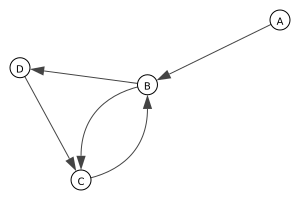

In [4]:
random.seed(4321)
g = ig.Graph.Erdos_Renyi(n=4,p=0,directed=True)
g.vs['label'] = ['A','B','C','D']
g.vs['color'] = 'white'
g.add_edges([(0,1),(1,2),(1,3),(2,1),(3,2)])
ly = g.layout_fruchterman_reingold()
#ig.plot(g,'tiny.eps', layout=ly, bbox=(0,0,300,200),vertex_label_size=10)
ig.plot(g, layout=ly, bbox=(0,0,300,200), vertex_label_size=10)

# Datasets

* $abcd$: is a small ABCD graph (100 nodes), mainly for visualization and quick examples
* $ABCD$: is a larger ABCD graph (1000 nodes), for experiments. It is noisy with $\xi=0.6$.
* $ABCD2$: Similar to $ABCD$ but less noisy with $\xi=0.2$.
* $zac$: Zachary (karate club) graph, mainly for visualzation

The small $abcd$ graph was generated with the following parameters:

```
n = "100"                     # number of vertices in graph
t1 = "3"                      # power-law exponent for degree distribution
d_min = "5"                   # minimum degree
d_max = "15"                  # maximum degree
d_max_iter = "1000"           # maximum number of iterations for sampling degrees
t2 = "2"                      # power-law exponent for cluster size distribution
c_min = "25"                  # minimum cluster size
c_max = "50"                  # maximum cluster size
xi = "0.2"                    # fraction of edges to fall in background graph
```

The larger $ABCD$ and $ABCD2$ graphs were generated with the following parameters:

```
n = "1000"                     # number of vertices in graph
t1 = "3"                       # power-law exponent for degree distribution
d_min = "10"                   # minimum degree
d_max = "100"                  # maximum degree
d_max_iter = "1000"            # maximum number of iterations for sampling degrees
t2 = "2"                       # power-law exponent for cluster size distribution
c_min = "50"                   # minimum cluster size
c_max = "150"                  # maximum cluster size
xi = "0.6" or "0.2"            # fraction of edges to fall in background graph
```


### Load the small ABCD graph and visualize

Beware: node names are 1-based and are distinct from vertex ids.

100 vertices, 350 edges, mean degreee: 7.0 , no. of communities: 3


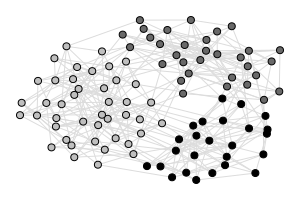

In [5]:
## read graph and communities
abcd = ig.Graph.Read_Ncol(datadir+'ABCD/abcd_100.dat',directed=False)
c = np.loadtxt(datadir+'ABCD/abcd_100_comms.dat',dtype='uint16',usecols=(1))

## assign correct community based on node names
abcd.vs['comm'] = [c[int(x['name'])-1] for x in abcd.vs]

## print a few stats
print(abcd.vcount(),'vertices,',abcd.ecount(),'edges,','mean degreee:',np.mean(abcd.degree()),
      ', no. of communities:',max(abcd.vs['comm']))

## define the colors and node sizes here
abcd.vs['size'] = 7
abcd.es['color'] = cls_edges
abcd.vs['color'] = [cls[i-1] for i in abcd.vs['comm']]
ig.plot(abcd, bbox=(0,0,300,200))

### Load the larger ABCD graphs and visualize

This is a larger graph with lots of noise edges ($\xi$=0.6). Nore colours refer to the communities.
With this amount of noise, the communities are far from obvious on a 2-dimensional layout.

The second one has stronger communities ($\xi$=0.2).


In [6]:
## read graph and communities
ABCD = ig.Graph.Read_Ncol(datadir+'ABCD/abcd_1000.dat',directed=False)
c = np.loadtxt(datadir+'ABCD/abcd_1000_comms.dat',dtype='uint16',usecols=(1))
ABCD.vs['comm'] = [c[int(x['name'])-1] for x in ABCD.vs]

## print a few stats
print(ABCD.vcount(),'vertices,',ABCD.ecount(),'edges,','mean degreee:',np.mean(ABCD.degree()),
      ', no. of communities:',max(ABCD.vs['comm']))

## define the colors and node sizes here
## node colors map to communities
ABCD.vs['size'] = 5
ABCD.es['color'] = 'gainsboro'
pal = ig.RainbowPalette(n=max(ABCD.vs['comm'])+1) 
ABCD.vs['color'] = [pal.get(int(i)) for i in ABCD.vs['comm']]

ig.plot(ABCD, bbox=(0,0,400,300)) ## communities are far from obvious in 2d layout!

1000 vertices, 8327 edges, mean degreee: 16.654 , no. of communities: 12


In [7]:
## read graph and communities
ABCD2 = ig.Graph.Read_Ncol(datadir+'ABCD/abcd_1000_xi2.dat',directed=False)
c = np.loadtxt(datadir+'ABCD/abcd_1000_xi2_comms.dat',dtype='uint16',usecols=(1))
ABCD2.vs['comm'] = [c[int(x['name'])-1] for x in ABCD2.vs]

## print a few stats
print(ABCD2.vcount(),'vertices,',ABCD2.ecount(),'edges,','mean degreee:',np.mean(ABCD2.degree()),
      ', no. of communities:',max(ABCD2.vs['comm']))

## define the colors and node sizes here
## node colors map to communities
ABCD2.vs['size'] = 5
ABCD2.es['color'] = 'gainsboro'
pal = ig.RainbowPalette(n=max(ABCD2.vs['comm'])+1) 
ABCD2.vs['color'] = [pal.get(int(i)) for i in ABCD2.vs['comm']]

ig.plot(ABCD2, bbox=(0,0,400,300)) ## communities are clear here

1000 vertices, 8678 edges, mean degreee: 17.356 , no. of communities: 12


### Zachary (karate club) graph


In [8]:
zac = ig.Graph.Read_Ncol(datadir+'Zachary/zachary.edgelist',directed=False)
c = np.loadtxt(datadir+'Zachary/zachary.communities',dtype='uint16')
zac.vs['comm'] = [c[int(x['name'])] for x in zac.vs]
## layout stored from Chapter 5 notebook
with open(datadir+"Zachary/layout.pkl","rb") as fn:
    ly_zac = pickle.load(fn)
zac['layout'] = [ly_zac[int(x['name'])] for x in zac.vs] 
zac.vs['size'] = 7
zac.es['color'] = cls_edges
zac.vs['color'] = [cls[i*2] for i in zac.vs['comm']]


## Graph layouts 

We show a variety of graph layout functions available in `igraph` on the Zachary graph.


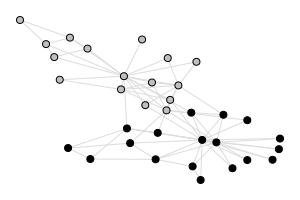

In [9]:
## Fruchterman-Reingold layout (saved layout)
#ig.plot(zac, 'layout_fr.eps', layout=zac.vs['layout'], bbox=(0,0,300,200))
ig.plot(zac, bbox=(0,0,300,200))


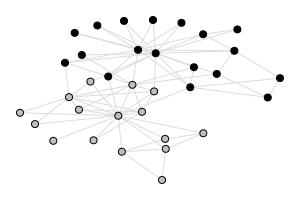

In [10]:
## Kamada-Kawai layout
random.seed(123)
ly = zac.layout('kk')

#ig.plot(zac, 'layout_kk.eps', layout=ly, bbox=(0,0,300,200))
ig.plot(zac, layout=ly, bbox=(0,0,300,200))


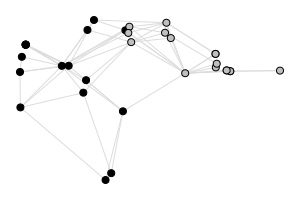

In [11]:
## Multidimensional scaling layout
random.seed(123)
ly = zac.layout('mds')

#ig.plot(zac, 'layout_mds.eps', layout=ly, bbox=(0,0,300,200))
ig.plot(zac, layout=ly, bbox=(0,0,300,200))

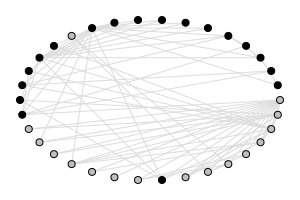

In [12]:
## Circular layout
random.seed(123)
ly = zac.layout('circle')

#ig.plot(zac, 'layout_circle.eps', layout=ly, bbox=(0,0,300,200))
ig.plot(zac, layout=ly, bbox=(0,0,300,200))

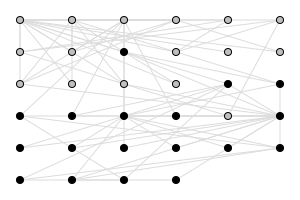

In [13]:
## Grid layout
random.seed(123)
ly = zac.layout('grid')

#ig.plot(zac, 'layout_grid.eps', layout=ly, bbox=(0,0,300,200))
ig.plot(zac, layout=ly, bbox=(0,0,300,200))

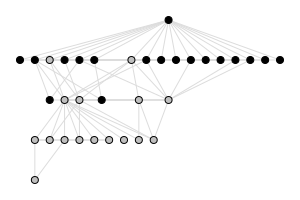

In [14]:
## Sugiyama (tree) layout
random.seed(123)
ly = zac.layout('sugiyama')

#ig.plot(zac, 'layout_tree.eps', layout=ly, bbox=(0,0,300,200))
ig.plot(zac, layout=ly, bbox=(0,0,300,200))

# Generate and compare several embeddings -- Zachary graph

We try a few graph embedding algorithms on the Zachary graph with
different parameters. For example, we try different embedding dimensions.

We run the following:
* node2vec with different values for $p$ and $q$
* HOPE with different similarities
* Laplacian Eigenmaps

For each embedding, we use the communities obtained with **ECG** along with the framework to compute the **graph embedding divergence** with the **CGE** Julia package. We visualize some good and bad results w.r.t. the global divergence score.

For embeddings with low divergence, we see good separation of the communities (even in 2-dim projection, using **UMAP**), while this is not the case for embeddings with high divergence.

Since we are going to compare embeddings for several graphs, we write the procedure as a function below. This function keeps a local copy of the best (`_embed_best`) and worst (`_embed_worst`) embeddings on disk, and returns the JS divergence (including local) for every test.


In [15]:
def test_embeddings(G, edgefile, commfile, run_hope=True, run_le=True, run_n2v=True, 
                    Dims=[2,4,8], local=False, verbose=False, seed=123):
    L = []         ## to store results
    best_jsd = 1   ## keep track of best JS-divergence
    worst_jsd = 0  ## and worst one.
    
    if(run_hope):
        for dim in Dims:
            for sim in ['katz','ppr','cn','aa']:
                X = Hope(G, sim=sim, dim=dim) 
                saveEmbedding(X, G)
                div = JS(edgefile, commfile,'_embed')      
                jsd = div[int(local)]
                if verbose:
                    print(dim,sim,jsd)
                if jsd < best_jsd:
                    os.system('cp _embed _embed_best')
                    best_jsd = jsd
                if jsd > worst_jsd:
                    os.system('cp _embed _embed_worst')
                    worst_jsd = jsd
                L.append([dim,'hope',sim,div[0],div[1]])
                
    if(run_le):
        for dim in Dims:
            X = LE(G, dim=dim)
            saveEmbedding(X, G)
            div = JS(edgefile, commfile,'_embed')
            jsd = div[int(local)]
            if verbose:
                print(dim,jsd)
            if jsd < best_jsd:
                os.system('cp _embed _embed_best')
                best_jsd = jsd
            if jsd > worst_jsd:
                os.system('cp _embed _embed_worst')
                worst_jsd = jsd
            L.append([dim,'le',' ',div[0],div[1]])

    if(run_n2v):
        graph = n2v.Graph(G.to_tuple_list(), directed=False, weighted=False)
        for dim in Dims:
            for (p,q) in [(1,0.5),(0.5,1),(1,1)]:
                ## using default values from original node2vec code
                nv = n2v.Node2Vec(graph, dim=dim, p=p, q=q, walk_length=80, window=5, seed=seed)
                nv.train(epochs=10, verbose=False)
                Y = np.array([nv.wv[i] for i in range(len(nv.wv))])
                saveEmbedding(Y, G)
                div = JS(edgefile,commfile, '_embed')
                jsd = div[int(local)]
                if verbose:
                    print(dim,p,q,jsd)
                if jsd < best_jsd:
                    os.system('cp _embed _embed_best')
                    best_jsd = jsd
                if jsd > worst_jsd:
                    os.system('cp _embed _embed_worst')
                    worst_jsd = jsd

                ## store results
                L.append([dim,'n2v',str(p)+' '+str(q),div[0],div[1]])               
    D = pd.DataFrame(L,columns=['dim','algo','param','jsd','local_jsd'])
    if local:
        D = D.sort_values(by='local_jsd',axis=0)
    else:
        D = D.sort_values(by='jsd',axis=0)
    return D


The code below takes about one minute to run as several embeddings are tested.


In [16]:
%%time
D = test_embeddings(zac, Dims=[2,4], edgefile=datadir+'Zachary/zachary.edgelist', 
                    commfile=datadir+'Zachary/zachary.ecg')
D.head()

Reading graph:   0%|          | 0/78 [00:00<?, ?it/s]

CPU times: user 1.39 s, sys: 72.6 ms, total: 1.46 s
Wall time: 1min 17s


dim  algo  param       jsd  local_jsd
12    2   n2v    1 1  0.003307     0.0699
13    4   n2v  1 0.5  0.005467     0.0430
9     4    le         0.006274     0.0171
1     2  hope    ppr  0.006766     0.0907
15    4   n2v    1 1  0.006950     0.0410

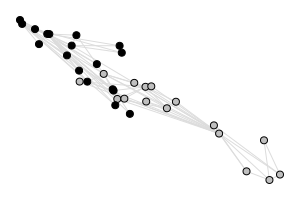

In [17]:
## plot top results
l = embed2layout(fn="_embed_best", seed=123)
ly = [l[int(v['name'])] for v in zac.vs]
#ig.plot(zac, 'zac_low_div.eps', layout=zac.vs['ly'], bbox=(0,0,300,200))
ig.plot(zac, layout=ly, bbox=(0,0,300,200))

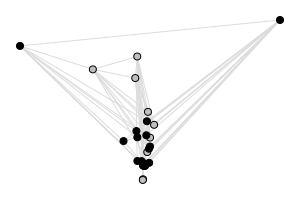

In [18]:
## plot result with largest divergence
l = embed2layout(fn="_embed_worst", seed=123)
ly = [l[int(v['name'])] for v in zac.vs]
#ig.plot(zac, 'zac_high_div.eps', layout=zac.vs['ly'], bbox=(0,0,300,200))
ig.plot(zac,layout=ly, bbox=(0,0,300,200))

# Compare embeddings -- small ABCD  graph

This is the same exercise as what we did above, this time for the 100-nodes ABCD graph.

We look at slightly higher embedding dimension as there are more nodes than the Zachary graph.


### effect of local divergence score

So far we considered the global Jenssen-Shannon divergence, where the objective is to preserve the community structure.

We show the best result with respect to the global divergence below, at we see that it preserves the community structure. We may want better separation of the nodes within community, based on their connectivity. This is what the local Jenssen-Shannon divergence can provide. 

Below we also show an embedding with lower local divergence. The result is an embedding that still preserves community structure, but nodes within community are more separated than with the global divergence.

The code below takes about one minute to run as several embeddings are tested.


In [19]:
%%time
D = test_embeddings(abcd, Dims=[2,16], edgefile=datadir+'ABCD/abcd_100.dat', 
                    commfile=datadir+'ABCD/abcd_100.ecg')
D.head()

Reading graph:   0%|          | 0/350 [00:00<?, ?it/s]

CPU times: user 49.5 s, sys: 1.42 s, total: 50.9 s
Wall time: 1min 11s


dim  algo  param       jsd  local_jsd
14   16   n2v  0.5 1  0.000045     0.0482
15   16   n2v    1 1  0.000121     0.0769
4    16  hope   katz  0.000253     0.3494
13   16   n2v  1 0.5  0.000254     0.0961
9    16    le         0.000333     0.0127

In [20]:
D.shape

(16, 5)

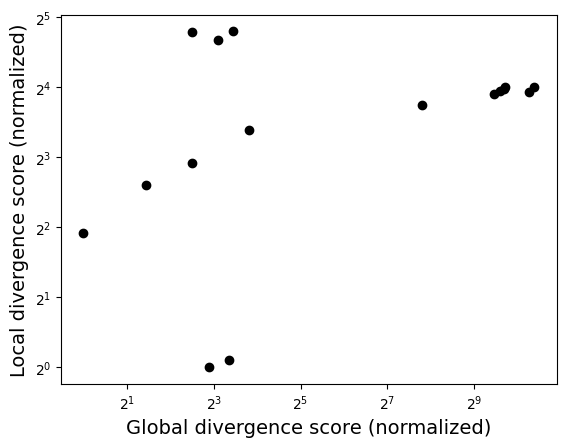

In [21]:
plt.loglog(D['jsd']/min(D['jsd']),D['local_jsd']/min(D['local_jsd']),'o',color='black', base=2)
plt.xlabel('Global divergence score (normalized)', fontsize=14)
plt.ylabel('Local divergence score (normalized)', fontsize=14);
#plt.savefig('abcd_div_1.eps');


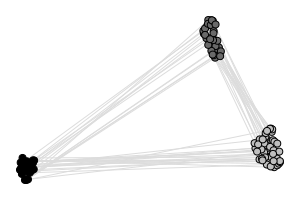

In [22]:
## plot result with lowest global JS divergence
l = embed2layout(fn="_embed_best", seed=123)
abcd.vs['ly'] = [l[int(v['name'])-1] for v in abcd.vs]
ig.plot(abcd, layout=abcd.vs['ly'], bbox=(0,0,300,200))
#ig.plot(abcd, "abcd_div_2.eps", layout=abcd.vs['ly'], bbox=(0,0,300,200))


In [23]:
## look at results with low local divergence
D.sort_values(by='local_jsd').head()

dim  algo  param       jsd  local_jsd
9    16    le         0.000333     0.0127
5    16  hope    ppr  0.000455     0.0136
14   16   n2v  0.5 1  0.000045     0.0482
15   16   n2v    1 1  0.000121     0.0769
13   16   n2v  1 0.5  0.000254     0.0961

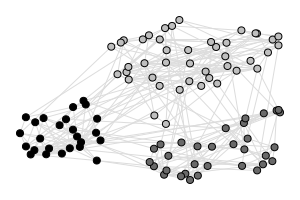

In [24]:
## Plot one of the top ones
X = Hope(abcd, sim='ppr', dim=16)
saveEmbedding(X, abcd)
l = embed2layout(seed=123)
abcd.vs['ly'] = [l[int(v['name'])-1] for v in abcd.vs]
ig.plot(abcd, layout=abcd.vs['ly'], bbox=(0,0,300,200))
#ig.plot(abcd, "abcd_div_3.eps", layout=abcd.vs['ly'], bbox=(0,0,300,200))


In [25]:
D.tail()

dim  algo  param       jsd  local_jsd
3     2  hope     aa  0.034727     0.1955
2     2  hope     cn  0.036974     0.1987
0     2  hope   katz  0.037301     0.2037
11    2   n2v  0.5 1  0.055111     0.1943
12    2   n2v    1 1  0.059604     0.2027

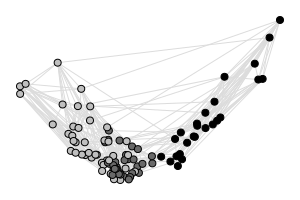

In [26]:
## Plot one of the bottom ones
X = Hope(abcd, sim='katz', dim=2)
saveEmbedding(X, abcd)
l = embed2layout(seed=123)
abcd.vs['ly'] = [l[int(v['name'])-1] for v in abcd.vs]
ig.plot(abcd, layout=abcd.vs['ly'], bbox=(0,0,300,200))
#ig.plot(abcd, "abcd_div_4.eps", layout=abcd.vs['ly'], bbox=(0,0,300,200))


# Classification on larger ABCD graph

We saw that embedding can be used to visualize graphs. Below we use graph embedding as a way to define a feature vector (point in vector space) for each node, and we use this representation to train a classifier.
We use a saved embedding (48-dimension running HOPE with 'ppr' similarity).

We split the data (the nodes) into a training and testing set. Using the training set, we build a random forest classification model where the classes are the communities for each node.

We then apply this model to the test set.

The graph has 1000 nodes; we use 250 for training and the rest for testing; we obtain good accuracy (around 90%).
What do you think will happen if we increase/decrease the size of the training set?

We also report the confusion matrix (details in section 6.5 of the book).

Finally, we compare with results obtained via a random classifier where we supply the correct number of classes only, or the number and relative sizes for the classes.

We see that our random forest model gives much better results that with a random classifier.


In [27]:
## load a saved embedding for the ABCD graph
X = readEmbedding(fn=datadir+"ABCD/abcd_1000_embed_best")
y = ABCD.vs['comm']

## train/test split
np.random.seed(1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=0)


In [28]:
# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')
# Fit on training data
model.fit(X_train, y_train)

# Class predictions on test data
y_pred = model.predict(X_test)

In [29]:
## Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

## percent correct -- this can vary slightly as we split train/test randomly
print('\naccuracy:',sum(cm.diagonal())/sum(sum(cm)),'\n')
#print(bmatrix(cm))

[[78  1  4  0  0  2  3  0  3  0  1  0]
 [ 0 77  0  1  1  0  0  1  0  0  0  0]
 [ 1  0 71  0  1  0  0  0  3  0  0  0]
 [ 1  1  1 64  0  1  0  1  1  0  0  0]
 [ 1  0  2  1 77  0  0  1  0  1  0  0]
 [ 0  0  0  1  1 54  0  1  0  0  0  0]
 [ 1  1  0  0  1  3 53  3  2  0  0  0]
 [ 0  0  0  1  1  0  0 42  0  0  0  0]
 [ 0  0  0  0  1  1  0  1 45  0  0  0]
 [ 1  0  0  0  0  1  0  0  1 44  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 42  0]
 [ 1  1  1  0  0  4  2  2  1  0  0 35]]

accuracy: 0.9093333333333333 



In [30]:
## compare with random classifier
## assuming we know the number of classes (12) 
## and using class proportions from training data
np.random.seed(123)
ctr = Counter(y_train)
x = [ctr[i+1] for i in range(12)]
s = np.sum(x)
p = [i/s for i in x]
acc = []
for rep in range(30): ## repeat 30 times, we'll take average
    y_pred = [x+1 for x in np.random.choice(12, size=len(y_test), replace=True,p=p)]
    cm = confusion_matrix(y_test, y_pred)
    acc.append(sum(cm.diagonal())/sum(sum(cm)))
## accuracy
print('\nAverage accuracy:',np.mean(acc))



Average accuracy: 0.08813333333333334


# Clustering in embedded space

Again using the larger ABCD graph, we run some graph clustering algorithms (Leiden and ECG).
We run each algorithm several times are report two statistics:
* the modularity score of the clustering, and
* the adjusted mutual information (AMI) score when comparing with ground-truth (GT) communities.

We also try seeding Leiden with initial clusters obtained with k-means (in embedded space) where k=100.

We do the same this also with the clusters obtained when running k-means (with 5 choices for k) in embedded vector space. 
We use the same saved embedding than in the previous experiment. 
This time, we report:
* the CHS score (Calinski and Harabasz score, or Variance Ratio Criterion); higher value is indicative of better quality clustering
* the adjusted mutual information (AMI) score when comparing with ground-truth (GT) communities.

In practical applications where we do not have access to the ground-truth, we need some other measure to quantify the quality of the clusters we obtain, such as modularity or CHS. We report AMI for runs with highest score (w.r.t. modularity or CHS) for the 3 clustering algorithms.

The cell below can take a few minutes to run. Results are provided in a pkl file. Uncomment the cell below to re-run.


In [31]:
## load results from above cell
## load test results
with open(datadir+"ABCD/abcd_1000_clustering.pkl","rb") as fn:
    D = pickle.load(fn)

In [32]:
## AMI results with best scoring clustering for the 3 algorithms
x = list(D[[x.startswith('km') for x in D['algo']]].sort_values(by='scr',ascending=False)['ami'])[0]
print('K-Means best AMI:',x)

x = list(D[D['algo']=='lei'].sort_values(by='scr',ascending=False)['ami'])[0]
print('Leiden best AMI:',x)

x = list(D[D['algo']=='ecg'].sort_values(by='scr',ascending=False)['ami'])[0]
print('ECG best AMI:',x)

x = list(D[D['algo']=='km+lei'].sort_values(by='scr',ascending=False)['ami'])[0]
print('K-Means+Leiden best AMI:',x)


K-Means best AMI: 0.948197513421977
Leiden best AMI: 0.9952939155260987
ECG best AMI: 0.9952939155260987
K-Means+Leiden best AMI: 0.9952939155260987


Next, we summarize the results for all runs in a boxplot. 

Results with k-means are best when we supply the correct number of clusters (12). 

We see excellent results when using ECG or Leiden, in particular with the initial partition provided by k-means with large k=100.


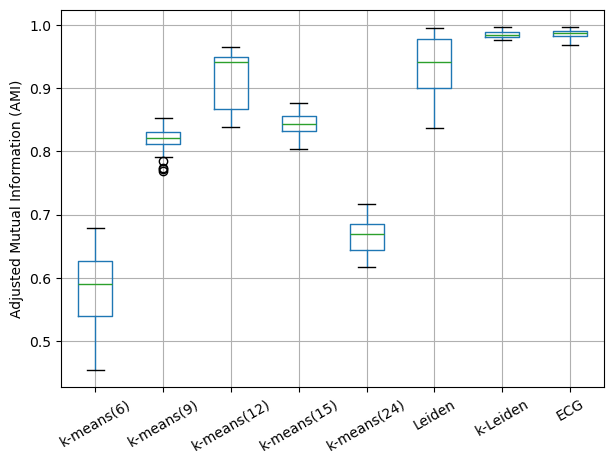

In [33]:
## boxplot the AMI results 
A = []
algo = ['km6','km9','km12','km15','km24','lei','km+lei','ecg']
for a in algo:
    A.append(D[D['algo']==a]['ami'])

B = pd.DataFrame(np.transpose(A), 
                 columns=['k-means(6)','k-means(9)','k-means(12)','k-means(15)',
                          'k-means(24)','Leiden','k-Leiden','ECG'])
B.boxplot(rot=30,figsize=(7,5))
plt.ylabel('Adjusted Mutual Information (AMI)')
plt.subplots_adjust(bottom=.125);
#plt.savefig('embed_cluster.eps');

Below we cluster using the DBSCAN algorithm after reducing the dimension via UMAP.
Running a good dimension reduction algorithm such as UMAP before clustering in vector space often gives better results. This is for illustration and you can experiment with different choices of parameter below as well as diffferent clustering algorithms such as HDBSCAN.

DBSCAN does not always cluster all the points, which can be quite useful in practice. Some points can be tagged as *outliers*. Below, we compute AMI with and without the outlying points. 
Result without outliers is quite good (recall that unlike k-means, we do not supply the number of communities here).


In [34]:
## load the saved low divergence embedding
ABCD_emb = readEmbedding(fn=datadir+"ABCD/abcd_1000_embed_best")

## We tried a few 'min_sample' and 'dim' with good results using 8 and 16 resp.
top = 0
dim = 16  ## reduce to this dimension
ms = 8    ## min-sample in DBSCAN
U = umap.UMAP(n_components=dim, random_state=1234, n_jobs=1).fit_transform(ABCD_emb)
## We try various 'eps' and pick the best via calinski_harabasz_score (CHS)
for e in np.arange(.4,.5,.0025): 
    cl = DBSCAN(eps=e, min_samples=ms).fit(U)
    labels = cl.labels_
    s = CHS(U,labels) ## CHS score
    if s > top:
        top=s
        e_top=e

## result with best CHS score
cl = DBSCAN(eps=e_top, min_samples=ms).fit(U)
b = [x>-1 for x in cl.labels_]
l = ABCD.vs['comm']
v = [l[i] for i in range(len(l)) if b[i]]
print('AMI without outliers:',AMI(v,cl.labels_[b]))
print('AMI with outliers:',AMI(ABCD.vs['comm'],cl.labels_))


AMI without outliers: 0.8788363103376909
AMI with outliers: 0.6632362136945023


# Link prediction

Given a graph, link prediction aims at finding pairs of nodes not linked by an edge that are the most likely to actually have an edge between them. This could happen if we have a partial view of a graph, for example if edges 
are observed over some period of time, which new edges are we most likely to observe next?

In order to simulate this situation, we take the ABCD graph with 1,000 nodes and drop 10% of the edges.
We re-compute the embedding (since the graph has changed), train a logistic regression model using pairs
of nodes with and without an edge, and apply the model to a test set consisting of the dropped edges, and other 
pairs of nodes not linked by an edge.

Given node embeddings $e(u)$ and $e(v)$, a representation for the node pair $(u,v)$ is obtained via some binary operator $B(e(u),e(v))$. We defined the same 4 operators as in https://arxiv.org/pdf/1607.00653.pdf at the beginning of this notebook, and will use the **Hadamar** operator in the experiments below.

We build the training data by considering all edges in the reduced graph, and an equal number of node pairs without an edge. From this data, we build a logistic regression model to predict edges vs non-edges. We then apply the model to the test set which includes the dropped edges, and the same number of non-edges.

First we tried with the current ABCD graph with noise parameter $\xi=0.6$.
Given the large number of "noise" edges, results are not very good, as expected.

We do another set of tests, this time with another ABCD graph with $\xi=0.2$ (`ABCD2`), with better results.

Since we are going to run this experiment for several graphs, we write the procedure as a function below. 


In [35]:
## default: model with Hadamard binary operator (other choices are 'l1', 'l2 and 'avg')
def link_pred_exp(G, test_eid, Emb, seed=123, op='had', return_plot=False, save_plot=False, verbose=True):
    Gp = G.copy()
    Gp.delete_edges(test_eid)
    X = Emb
    
    ## Build training data, first the edges
    F = []
    for e in Gp.es:
        F.append(binary_operator(X[e.tuple[0]],X[e.tuple[1]],op=op))
    size = len(F)
    f = [1]*size

    ## then for equal number of non-edges (we over-sample to drop edges or collisions from the list)
    ## nb: those could include some of the dropped edges, but avoiding those would not be realistic 
    e = [tuple(np.random.choice(Gp.vcount(),size=2,replace=False)) for i in range(2*size)]
    e = [(min(x),max(x)) for x in e if Gp.get_eid(x[0],x[1],directed=False,error=False) == -1]
    non_edges = list(set(e))[:size]
    for e in non_edges:
        F.append(binary_operator(X[e[0]],X[e[1]],op=op))
    F = np.array(F)
    f.extend([0]*size)

    ## train the model, here a logistic regression
    logreg = LogisticRegression(random_state=seed)
    logreg.fit(F,f)

    ## prepare test set, first with all dropped edges from G 
    X_test = []
    for i in test_eid:
        e = G.es[i]
        X_test.append(binary_operator(X[e.tuple[0]],X[e.tuple[1]],op=op))
    size = len(X_test)
    y_test = [1]*size

    ## then for equal number of non-edges (we over-sample to drop edges and collisions from the list)
    np.random.seed(seed)
    e = [tuple(np.random.choice(G.vcount(),size=2,replace=False)) for i in range(2*size)]
    e = [(min(x),max(x)) for x in e if G.get_eid(x[0],x[1],directed=False,error=False) == -1]
    non_edges = list(set(e))[:size]
    for e in non_edges:
        X_test.append(binary_operator(X[e[0]],X[e[1]],op=op))
    X_test = np.array(X_test)
    y_test.extend([0]*size)

    ## apply the model to test data
    _acc = logreg.score(X_test, y_test)
    _auc = roc_auc_score(y_test, logreg.predict_proba(X_test)[:,1])
    if verbose:
        print('Accuracy of logistic regression classifier with',op,
              'on test set: {:.2f}'.format(_acc))
        print('AUC:',_auc)    

    if return_plot:
        logit_roc_auc = roc_auc_score(y_test, logreg.predict_proba(X_test)[:,1])
        fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
        plt.figure()
        plt.plot(fpr, tpr, color='gray',label='Logistic Regression (AUC = %0.2f)' % logit_roc_auc)
        plt.plot([0, 1], [0, 1],'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=14)
        plt.ylabel('True Positive Rate', fontsize=14)
        plt.title('')
        plt.legend(loc="lower right")
        if save_plot:
            plt.savefig('embed_link.eps')
        plt.show();
    
    if verbose==False:
        return _acc, _auc
    

### Link prediction with noisy ABCD graph $\xi = 0.6$

The results are better than random, but not great; recall that $\xi$=0.6, so the majority of edges are noise to start with, so link prediction is very hard in this case. We try with less noisy graph next.

The cell below can take a few minutes - uncomment to run


In [36]:
## pick 10% edges at random for test set, save new graph as Gp
np.random.seed(123)
test_size = int(np.round(.1*ABCD.ecount()))
test_eid = np.random.choice(ABCD.ecount(),size=test_size,replace=False)
Gp = ABCD.copy()
Gp.delete_edges(test_eid)

## low divergence embedding from test in previous cell
X = LE(Gp, dim=8)
link_pred_exp(ABCD, test_eid, X)


Accuracy of logistic regression classifier with had on test set: 0.61
AUC: 0.6107576283814846


### Link prediction less noisy ABCD graph $\xi = 0.2$


Again the cell below can take a few minutes - uncomment to run.

We saved the results in a pkl file.

In [37]:
## load results from pickle file
with open(datadir+"ABCD/abcd_1000_xi2_linkpred.pkl","rb") as f:
    D = pickle.load(f)


In [38]:
print('global divergence:',tau(D['jsd'],D['acc']).statistic)
print('local divergence:',tau(D['local_jsd'],D['acc']).statistic)

global divergence: -0.18840579710144928
local divergence: -0.6811594202898551


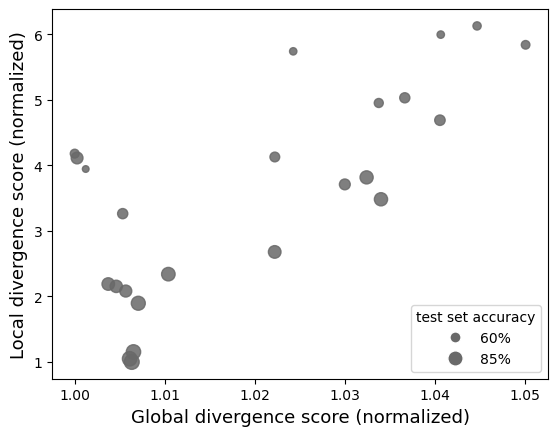

In [39]:
no_of_balls = D.shape[0]
x = D['jsd']/min(D['jsd'])
y = D['local_jsd']/min(D['local_jsd'])
acc = D['acc']
areas = [(25*i-10)**2 for i in acc]
plt.figure()
plt.scatter(x, y, s=areas, alpha=0.85, color='dimgrey')
#plt.axis([0.0, 1.0, 0.0, 1.0])
plt.xlabel("Global divergence score (normalized)", fontsize=13)
plt.ylabel("Local divergence score (normalized)", fontsize=13)
line1 = mpl.lines.Line2D([], [], color='white', marker='o',markersize=8, markerfacecolor="dimgrey")
line2 = mpl.lines.Line2D([], [], color='white',marker='o', markersize=11,  markerfacecolor="dimgrey")
plt.legend((line1, line2), ('60%', '85%',), numpoints=1, loc=4, title='test set accuracy')
plt.show();
#plt.savefig('embed_link_bubbles.eps');


In [40]:
D.head()

dim algo  param       jsd  local_jsd       acc       auc
21    8  n2v  1 0.5  0.001802     0.0392  0.827765  0.849210
22    8  n2v  0.5 1  0.001802     0.0411  0.816244  0.843529
23    8  n2v    1 1  0.001803     0.0452  0.813364  0.844863
14    8   le         0.001804     0.0743  0.802419  0.857234
19    4  n2v  0.5 1  0.001801     0.0816  0.745968  0.794291

Reading graph:   0%|          | 0/7810 [00:00<?, ?it/s]

Accuracy of logistic regression classifier with had on test set: 0.83
AUC: 0.8565389475248998


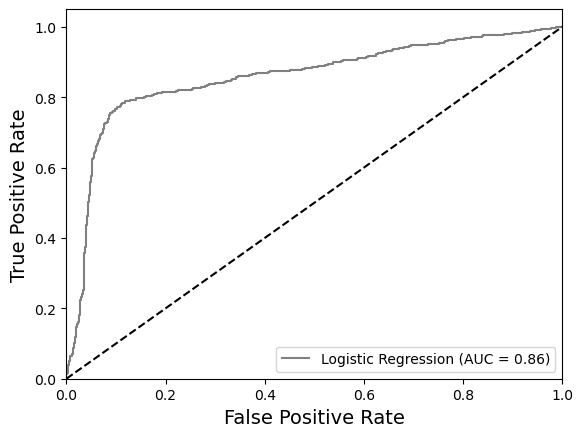

In [41]:
## pick 10% edges at random, save new graph as Gp
test_size = int(np.round(.1*ABCD2.ecount()))
np.random.seed(123) ## for reproducibility
test_eid = np.random.choice(ABCD2.ecount(),size=test_size,replace=False)
ABCD2_sampled = ABCD2.copy()
ABCD2_sampled.delete_edges(test_eid)

## low divergence embedding from test in previous cell
graph = n2v.Graph(ABCD2_sampled.to_tuple_list(), directed=False, weighted=False)
nv = n2v.Node2Vec(graph, dim=8, p=1.0, q=0.5, walk_length=80, window=5, seed=123)
nv.train(epochs=10, verbose=False)
X = np.array([nv.wv[i] for i in range(len(nv.wv))])
link_pred_exp(ABCD2, test_eid, X, return_plot=True, save_plot=False)


Accuracy of logistic regression classifier with had on test set: 0.64
AUC: 0.6858117076174902


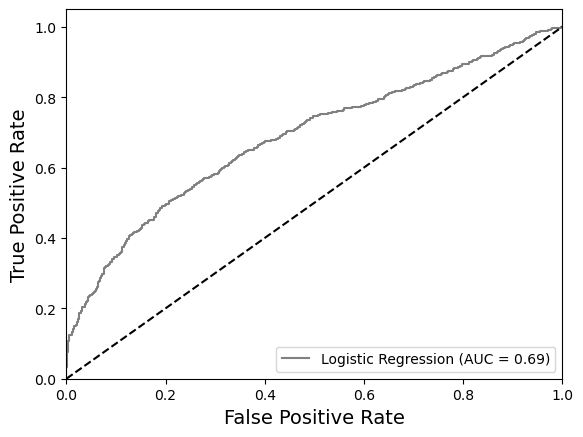

In [42]:
## high local divergence embedding from test in previous cell
X = Hope(ABCD2_sampled, sim='cn', dim=2)
link_pred_exp(ABCD2, test_eid, X, return_plot=True)


## Supervised learning - using classification accuracy to compare embeddings

We saw earlier an **unsupervised** method for selecting good graph embeddings where we computed some divergence score. In **supervised** case, it is usually better to take advantage of the known labels to compare embeddings.
With this larger experiment, we do the following using the 1,000 nodes ABCD graph. Recall that in this case, the class is the ground-truth community for each node. 

* we partition the nodes into training, validation and test sets in proportion 25%/25%/50%
* we generate 40 different embeddings (3 algorithms, different parameters)
* from each embedding, 
  * we compute the JS divergences (unsupervised score)
  * we use the training data to build a classification model (random forest)
  * we apply this model to the validation set 
  * we compute the accuracy score (supervised score) 

The code to do this is commented out in the cell below as this can take several minutes to run. 
A pickle file with the results is included in data directory and can be read directly.


In [43]:
## load results from pickle file
with open(datadir+"ABCD/abcd_1000_embeddings.pkl","rb") as f:
    id_train,id_val,id_trainval,id_test,L = pickle.load(f)

## labels for train/validation/test sets
y_all = ABCD.vs['comm']
y_train = [y_all[i] for i in id_train]
y_trainval = [y_all[i] for i in id_trainval] ## training+validation sets
y_val = [y_all[i] for i in id_val]
y_test = [y_all[i] for i in id_test]


Below we compute the rank-based  Kendall-tau correlation between the divergence score (unsupervised) and the accuracy score (supervised). We see negative correlation which is to be expected since respectively low divergence and high accuracy are better.

In [44]:
## correlation: divergence and accuracy
R = pd.DataFrame(L,columns=['dim','algo','param','div_g','div_l','acc'])
from scipy.stats import kendalltau as tau
print('global divergence:',tau(R['div_g'],R['acc']).statistic)
print('local divergence:',tau(R['div_l'],R['acc']).statistic)


global divergence: -0.7583572615780839
local divergence: -0.44373072933081337


In the next 2 cells, we show the top results on the validation set respectively for the divergence and accuracy scores. We also add two columns with the respective ranks.


In [45]:
## sort by JS-divergence on validation set
size = R.shape[0]
R = R.sort_values(by='div_g',axis=0,ascending=True)
R['rank_div_g'] = np.arange(1,size+1,1)
R = R.sort_values(by='div_l',axis=0,ascending=True)
R['rank_div_l'] = np.arange(1,size+1,1)
R['rank_div'] = (R['rank_div_g'] + R['rank_div_l'])/2
R = R.sort_values(by='rank_div',axis=0,ascending=True)
R.head()


dim  algo param     div_g   div_l    acc  rank_div_g  rank_div_l  rank_div
4    32    le     0  0.000746  0.0271  0.920           1           1       1.0
24   32  hope   ppr  0.001945  0.0531  0.900           3           2       2.5
3    16    le     0  0.001165  0.0699  0.928           2           3       2.5
20   16  hope   ppr  0.002129  0.1117  0.920           4           4       4.0
2     8    le     0  0.007074  0.1320  0.876           6           5       5.5

In [46]:
## sort by Accuracy on validation set
R = R.sort_values(by='acc',axis=0,ascending=False)
size = R.shape[0]
R['rank_acc'] = np.arange(1,size+1,1)
R.head()


dim  algo param     div_g   div_l    acc  rank_div_g  rank_div_l  \
3    16    le     0  0.001165  0.0699  0.928           2           3   
4    32    le     0  0.000746  0.0271  0.920           1           1   
20   16  hope   ppr  0.002129  0.1117  0.920           4           4   
24   32  hope   ppr  0.001945  0.0531  0.900           3           2   
2     8    le     0  0.007074  0.1320  0.876           6           5   

    rank_div  rank_acc  
3        2.5         1  
4        1.0         2  
20       4.0         3  
24       2.5         4  
2        5.5         5

Below we show the lowest accuracy results. We see that there is quite a range of accuracy on the validation set!


In [47]:
R.tail()

dim  algo  param     div_g   div_l    acc  rank_div_g  rank_div_l  \
7     2  hope     cn  0.059959  0.2928  0.200          35          38   
5     2  hope   katz  0.061800  0.2984  0.200          37          40   
26    2   n2v  0.5 1  0.072984  0.2671  0.180          40          28   
27    2   n2v    1 1  0.070804  0.2730  0.168          39          30   
25    2   n2v  1 0.5  0.070208  0.2849  0.168          38          34   

    rank_div  rank_acc  
7       36.5        36  
5       38.5        37  
26      34.0        38  
27      34.5        39  
25      36.0        40

###  Apply the models to the test set. 

In the previous cells, we built a table ranking the different algorithms w.r.t. accuracy and divergence using the training and validation sets. Here, we go through the same algorithms in (decreasing) order of accuracy, re-train with each model using the training and validation sets, and apply to the test set.

This takes several minutes to run so a pickle file is provided with the results.

Uncomment the cell below to re-run.


In [48]:
## load test results
with open(datadir+"ABCD/abcd_1000_embeddings_test.pkl","rb") as fn:
    top_acc = pickle.load(fn)

R['test'] = top_acc
print('mean accuracy over all models on the test set:',np.mean(R['test']))


mean accuracy over all models on the test set: 0.57365


In [49]:
## top results w.r.t. accuracy on the test set
R = R.sort_values(by='test',axis=0,ascending=False)
R['rank_test'] = np.arange(1,size+1,1)
R.head()

dim  algo param     div_g   div_l    acc  rank_div_g  rank_div_l  \
4    32    le     0  0.000746  0.0271  0.920           1           1   
3    16    le     0  0.001165  0.0699  0.928           2           3   
24   32  hope   ppr  0.001945  0.0531  0.900           3           2   
20   16  hope   ppr  0.002129  0.1117  0.920           4           4   
2     8    le     0  0.007074  0.1320  0.876           6           5   

    rank_div  rank_acc   test  rank_test  
4        1.0         2  0.964          1  
3        2.5         1  0.944          2  
24       2.5         4  0.938          3  
20       4.0         3  0.936          4  
2        5.5         5  0.896          5

In [50]:
R.tail()

dim  algo  param     div_g   div_l    acc  rank_div_g  rank_div_l  \
5     2  hope   katz  0.061800  0.2984  0.200          37          40   
8     2  hope    ppr  0.060917  0.2647  0.220          36          26   
25    2   n2v  1 0.5  0.070208  0.2849  0.168          38          34   
26    2   n2v  0.5 1  0.072984  0.2671  0.180          40          28   
27    2   n2v    1 1  0.070804  0.2730  0.168          39          30   

    rank_div  rank_acc   test  rank_test  
5       38.5        37  0.224         36  
8       31.0        34  0.202         37  
25      36.0        40  0.162         38  
26      34.0        38  0.150         39  
27      34.5        39  0.136         40

Next, we take the top-10 algorithms w.r.t. divergence on the validation set, and the top-10 algorithms w.r.t. accuracy on the valudation set. We then plot the distribution of results (accuracy) over the test set via box-plots.

As expected, using accuracy (supervised score) yields better results, but the results obtained with the (unsupervised) divergence score are also quite good.


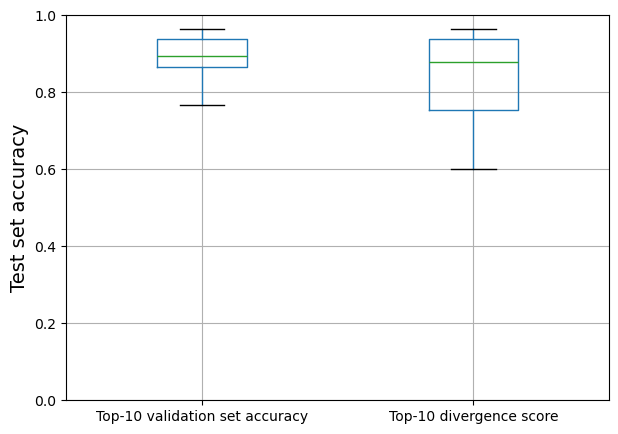

In [51]:
## top results on test set w.r.t. divergence on validation set
R = R.sort_values(by='rank_div',axis=0,ascending=True)
top_div = R['test'].iloc[:10]

## top results on test set w.r.t. accuracy on validation set
R = R.sort_values(by='acc',axis=0,ascending=False)
top_acc = R['test'].iloc[:10]

## pd with mu
B = pd.DataFrame(np.transpose(np.array([top_acc,top_div])), 
                 columns=['Top-10 validation set accuracy','Top-10 divergence score'])
B.boxplot(rot=0,figsize=(7,5), widths=.33)
plt.ylim((0,1))
plt.ylabel('Test set accuracy',fontsize=14);
#plt.savefig('embed_classify.eps')


Another way to compare the results is to plot the accuracy results on the test set as a function of the rank of the algorithms w.r.t. the accuracy score on the validation set (next cell) or the divergence score on the validation set (second next cell).

The correlation is very clear in the first case, and is still quite strong in the second case.

correlation: -0.9851649877716068


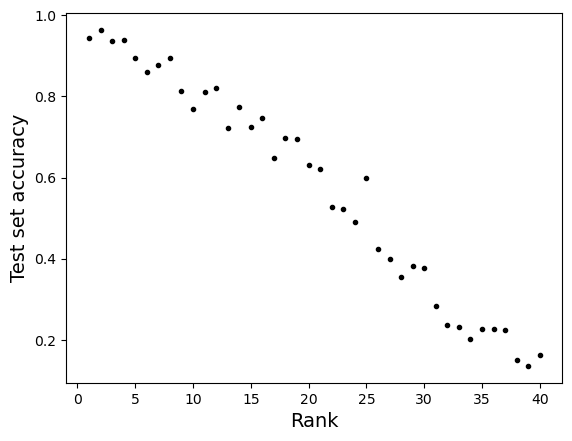

In [52]:
plt.plot(R['rank_acc'],R['test'],'.',color='black')
plt.xlabel('Rank',fontsize=14)
plt.ylabel('Test set accuracy',fontsize=14);
#plt.savefig('rank_accuracy.eps');
print('correlation:',np.corrcoef(R['rank_acc'],R['test'])[0,1])

correlation: -0.9133673170293662


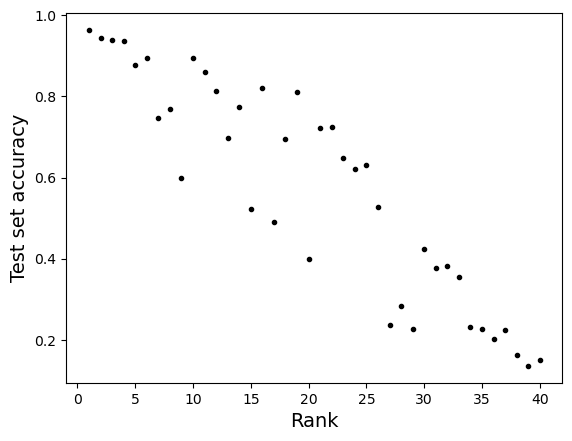

In [53]:
plt.plot(R['rank_div_g'],R['test'],'.',color='black')
plt.xlabel('Rank',fontsize=14)
plt.ylabel('Test set accuracy',fontsize=14);
#plt.savefig('rank_divergence.eps');
print('correlation:',np.corrcoef(R['rank_div_g'],R['test'])[0,1])

Finally, we compare with accuracy obtained with a random classifier, averaging over several runs.

In [54]:
## random classification
np.random.seed(123)
ctr = Counter(y_trainval)
x = [ctr[i+1] for i in range(12)]
s = np.sum(x)
p = [i/s for i in x]
acc = []
for rep in range(30):
    y_pred = [x+1 for x in np.random.choice(12,size=len(y_test),replace=True,p=p)]
    cm = confusion_matrix(y_test, y_pred)
    acc.append(sum(cm.diagonal())/sum(sum(cm)))
print('\nRandom classifier average accuracy on test set:',np.mean(acc))



Random classifier average accuracy on test set: 0.08539999999999998


### Test set accuracy vs both divergence scores

Recall that we took the average rank of the glocal and divergence scores to obtain the (unsupervised) ranking of the embeddings. 

Below, we plot the test set accuracy vs both divergence scores.
As we already saw with the correlation valuers, the global score is a better predictor here, but the local score is still correlated as expected, with a few points having high local divergence, low global divergenc and high accuracy (so using only the local score would ranked those as bad).


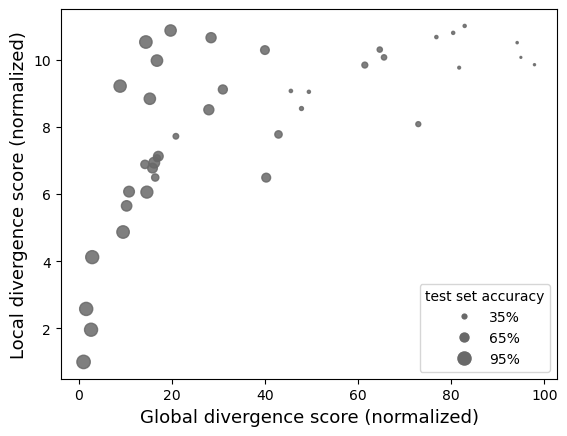

In [55]:
no_of_balls = R.shape[0]
x = R['div_g']/min(R['div_g'])
y = R['div_l']/min(R['div_l'])
acc = R['test']
areas = [(10*x)**2 for x in acc]

plt.figure()
plt.scatter(x, y, s=areas, alpha=0.85, color='dimgrey')
#plt.axis([0.0, 1.0, 0.0, 1.0])
plt.xlabel("Global divergence score (normalized)", fontsize=13)
plt.ylabel("Local divergence score (normalized)", fontsize=13)
line1 = mpl.lines.Line2D([], [], color='white', marker='o',markersize=5.5, markerfacecolor="dimgrey")
line2 = mpl.lines.Line2D([], [], color='white',marker='o', markersize=8.5, markerfacecolor="dimgrey")
line3 = mpl.lines.Line2D([], [], color='white',marker='o', markersize=11.5,  markerfacecolor="dimgrey")
plt.legend((line1, line2, line3), ('35%', '65%', '95%',), numpoints=1, loc=4, title='test set accuracy')
plt.show();
#plt.savefig('embed_classify_bubbles.eps')

# GCN structural embedding of Zachary graph

In the cells below, we embed the nodes from the Zachary graph using a simple GCN model (graph convolution net) with one hidden layer and 3-dimensional output. This can be done via ```fit_transform```. For structural node features, we use each node's degree and number of edges in its egonet. We cluster the resulting embedding with k-means setting k=3. 

We plot the embedding (after dimension reduction via UMAP) with colors representing the k-means clusters.
We see good separation between the 3 clusters.

In the next cell we plot the graph this time using the Fruchterman-Reingold layout we saw before.
We see that this embedding finds the central/intermediate/peripheral nodes as its clusters.


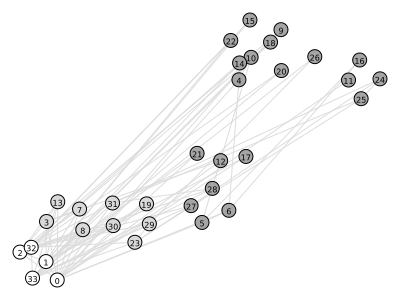

In [56]:
## GCN embedding of karate graph + kmeans with 3 communities
zac_A = zac.get_adjacency_sparse()

## GCN
hidden_dim = 5
n_labels = 3
gnn = skn.gnn.GNNClassifier(dims=[hidden_dim, n_labels],
                    layer_types='Conv',
                    activations='ReLu',
                    verbose=False)

## for structural features, use degree and number of edges in egonet
features = np.stack( (
    np.array(zac.degree()),
    np.array([zac.subgraph(V).ecount() for V in zac.neighborhood()]),
    ), axis=1 
)
labels = np.zeros(zac.vcount()) ## embedding, no need for node labels

## compute the embedding
zac_emb = gnn.fit_transform(zac_A, features, labels=labels, n_epochs=25, random_state=42)

## apply k-means to this embedding and color the nodes 
kmeans = KMeans(n_clusters=3, random_state=123, n_init="auto").fit(zac_emb)
zac.vs['kmeans'] = kmeans.labels_
greys = mpl.colormaps['Greys']
cls = [greys(0),greys(.45),greys(.25)]
zac.vs['color'] = [cls[i] for i in zac.vs['kmeans']]
zac.vs['size'] = 14
zac.vs['label_size'] = 8

## map the structural embedding to 2-d via UMAP for visualization
Y = umap.UMAP(random_state=123, n_jobs=1).fit_transform(zac_emb)
ig.plot(zac, layout = Y, bbox=(0,0,400,300), vertex_label=zac.vs['name'])
#ig.plot(zac, 'zac_gcn_1.eps', layout = Y, bbox=(0,0,400,300), vertex_label=zac.vs['name'])


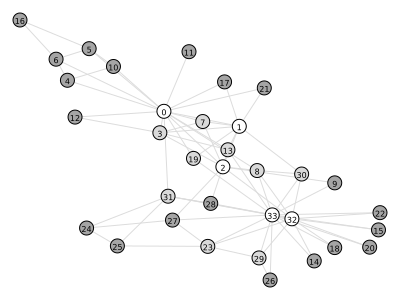

In [57]:
## Now with Fruchterman-Reingold layout
ig.plot(zac, bbox=(0,0,400,300), vertex_label=zac.vs['name'])
#ig.plot(zac, 'zac_gcn_2.eps', layout = zac.vs['layout'], bbox=(0,0,400,300), vertex_label=zac.vs['name'])


Below we train another GCN, but with 1-dimension output layer (using same node features), so we get a 1dimensional embedding that we can use to order the nodes, which we show in the second cell below (where the node labels are replaced by their respective ranks in the ordering). 

We see a clear ranking from the most central nodes to the peripherial nodes.


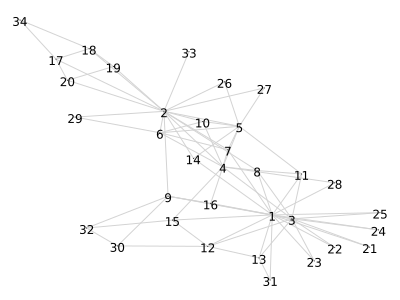

In [58]:
## 1-d embedding allows for node ordering
n_labels = 1
gnn = skn.gnn.GNNClassifier(dims=[hidden_dim, n_labels],
                    layer_types='Conv',
                    activations='ReLu',
                    verbose=False)
emb_1 = gnn.fit_transform(zac_A, features, labels=labels, n_epochs=20, random_state=42, history=True)
roles = np.argsort(emb_1.flatten())
for i in range(len(roles)):
    zac.vs[roles[i]]['label'] = i+1
ig.plot(zac, bbox=(400,300), edge_color='lightgrey', 
        vertex_size=.1, vertex_label_color='black', vertex_label_size=12)


## semi-supervised learning with GCN

Below we consider the ground-turth labels in the Zachary graphs; recall that there are two communities. We mask 1/3 of the labels and train a GCN model using the other 2/3, given the ground-truth labels for those. 

We then use the trained model to predict the labels for the masked 1/3 of the nodes (a.k.a. the test set).

We see that we get a good accuracy, close top 90%, on the test set.

In [59]:
## classification - karate graph
labels = np.array(zac.vs['comm'], dtype='int')

np.random.seed(123)
train_mask = np.random.random(size=len(labels)) < 0.33 ## mask 1/3 of the nodes for training
labels[train_mask] = -1 ## the negative labels are ignored in the training

# GNN classifier with a single hidden layer
hidden_dim = 5
n_labels = 2 ## 2 ground-truth communities 
gnn = skn.gnn.GNNClassifier(dims=[hidden_dim, n_labels],
                    layer_types='Conv',
                    activations='ReLu',
                    verbose=False)

## for features, we simply use the adjacency matrix
features = zac_A

## fit the GCN
Pred = gnn.fit_predict(zac_A, features, labels=labels, n_epochs=50, random_state=42)

## apply to test set and compute accuracy
acc = get_accuracy_score(np.array(zac.vs['comm'])[train_mask], Pred[train_mask])
print('accuracy on the test set:', acc)

accuracy on the test set: 0.8888888888888888


# Embedding the Twitch dataset

In [60]:
import matplotlib.colors as colors
from sklearn.manifold import TSNE


### running node2vec and UMAP/t-SNE

Here are the steps to follow to re-create the experiment below:
* get the dataset from https://snap.stanford.edu/data/twitch_gamers.html
* build a dataframe with all node features
* build the graph from the edge list and run node2vec on the graph
* run UMAP and t-SNE to get 2-dim mappings for visualization, 

Uncomment the cell below to re-run this experiment.


In [61]:
## read the data obtained from the above experiment
with open(datadir+"Twitch/twitch.pkl", "rb") as fn:
    twitch = pickle.load(fn)
twitch.head()

views  mature  life_time  created_at  updated_at  numeric_id  \
0    7879       1        969  2016-02-16  2018-10-12           0   
1     500       0       2699  2011-05-19  2018-10-08           1   
2  382502       1       3149  2010-02-27  2018-10-12           2   
3     386       0       1344  2015-01-26  2018-10-01           3   
4    2486       0       1784  2013-11-22  2018-10-11           4   

   dead_account language  affiliate         X         Y     X_tsne     Y_tsne  
0             0       EN          1  2.431316  3.270270  -8.280227  79.176659  
1             0       EN          0 -0.352967 -2.807257 -36.260956  12.208278  
2             0       EN          1 -3.283926  1.143088  -6.933161 -47.618717  
3             0       EN          0  0.179443  3.700035  13.803396  58.124699  
4             0       EN          0 -2.857802  2.469590  35.316982   4.371580

### greyscale plot - highlight a few languages


In [62]:
## define a greyscale palette without the extremes
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap
cmap = plt.get_cmap('binary')
greyscale = truncate_colormap(cmap, 0.1,1.0)


In [63]:
## select a few languages to highlight
languages = ['French','Spanish','German']
language_codes = ['FR','ES','DE']
twitch['color'] = 0
twitch.loc[twitch.language==language_codes[0], 'color'] = 1
twitch.loc[twitch.language==language_codes[1], 'color'] = 2
twitch.loc[twitch.language==language_codes[2], 'color'] = 3


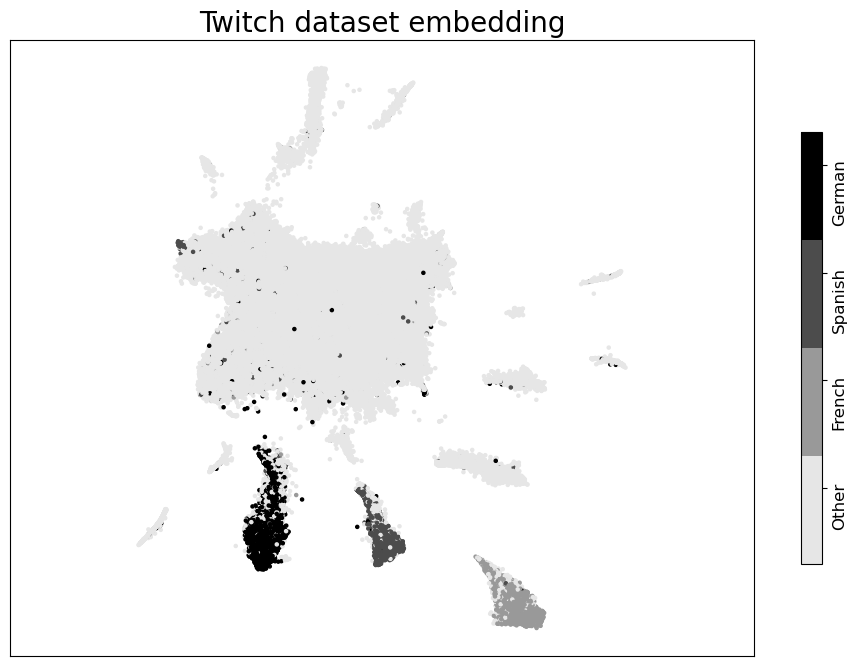

In [64]:
## plot - change ticklabels as required
plt.figure(figsize=(12,8))
plt.scatter(twitch.X, twitch.Y, c=twitch.color, cmap=greyscale, s=5)
plt.gca().set_aspect('equal', 'datalim')
ax = plt.colorbar(boundaries=np.arange(5)-0.5, shrink=0.7)
ax.set_ticks(np.arange(4)+.2)
ax.set_ticklabels(['Other']+languages, rotation=90, fontsize=12)
plt.xticks([])
plt.yticks([])
plt.title('Twitch dataset embedding', fontsize=20);
#plt.savefig('twitch_1.eps')


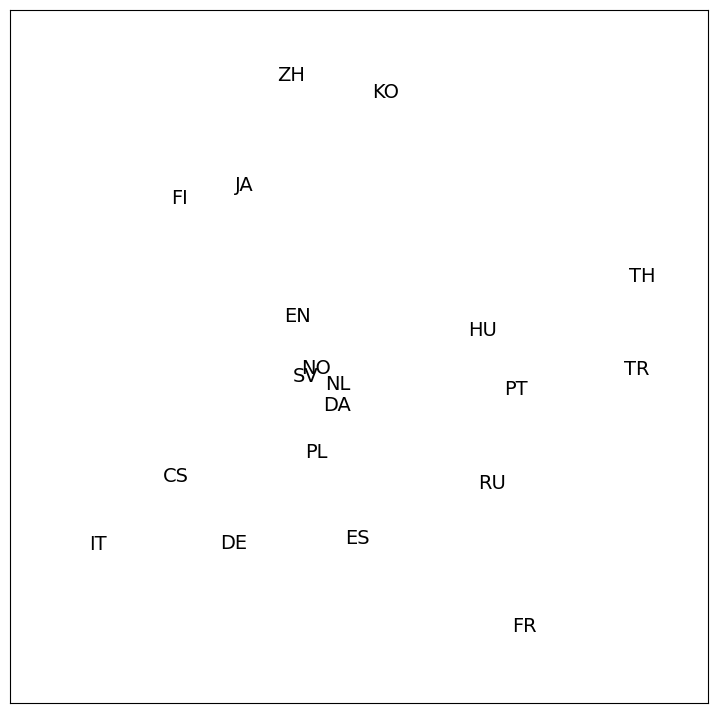

In [65]:
## compute the average position for every language in mapped 2-dim space
L = twitch.groupby(by='language').mean( ['X','Y'])
X = list(L.X)
Y = list(L.Y)
Z = list(L.index)
fig, ax = plt.subplots(figsize=(9,9))
ax.scatter(X, Y, s=0)
plt.xticks([])
plt.yticks([])
plt.xlim((min(X)-2,max(X)+2))
plt.ylim((min(Y)-2,max(Y)+2))
for i, txt in enumerate(Z):
    if txt != 'OTHER':
        ax.annotate(txt, (X[i], Y[i]), color='black', size=14)
#plt.savefig('twitch_2.eps')


## colorplot - all languages


In [66]:
x = np.sort([x for x in set(twitch.language) if x!='OTHER'])
lang_list = np.concatenate( ( np.array(['OTHER']), np.array([x[i] for i in np.arange(len(x)-1,-1,-1)])) )
num_lang = len(lang_list)
lang_dict = dict(zip(lang_list,np.arange(num_lang)))


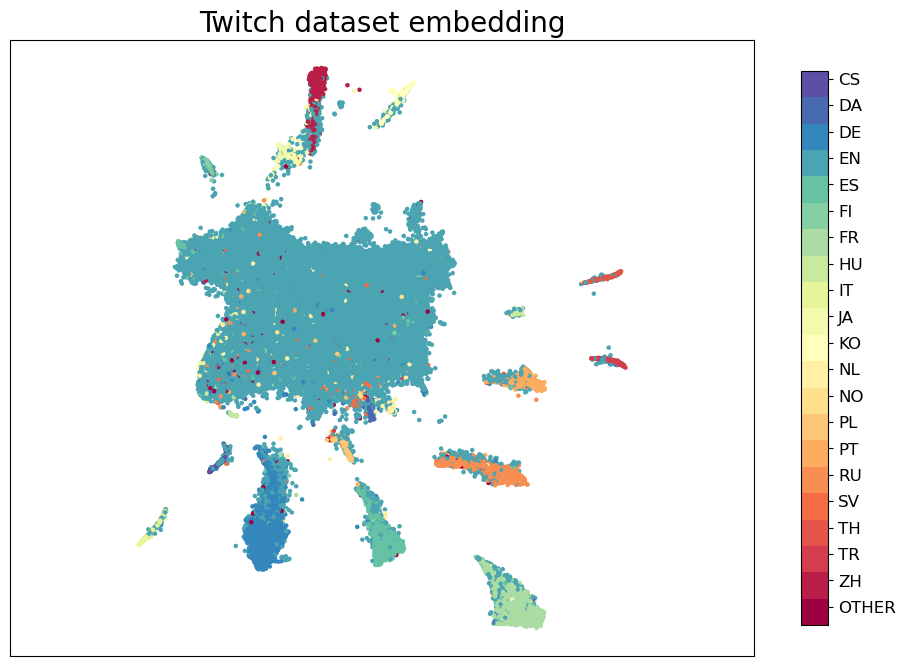

In [67]:
## plot - change ticklabels as required
plt.figure(figsize=(12,8))
plt.scatter(twitch.X, twitch.Y, c=[lang_dict[i] for i in twitch.language], cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
ax = plt.colorbar(boundaries=np.arange(num_lang+1)-0.5, shrink=0.9)
ax.set_ticks(np.arange(num_lang)+.2)
ax.set_ticklabels(lang_dict.keys(), fontsize=12)
plt.xticks([])
plt.yticks([])
plt.title('Twitch dataset embedding', fontsize=20);


### filtering - users with high number of view only

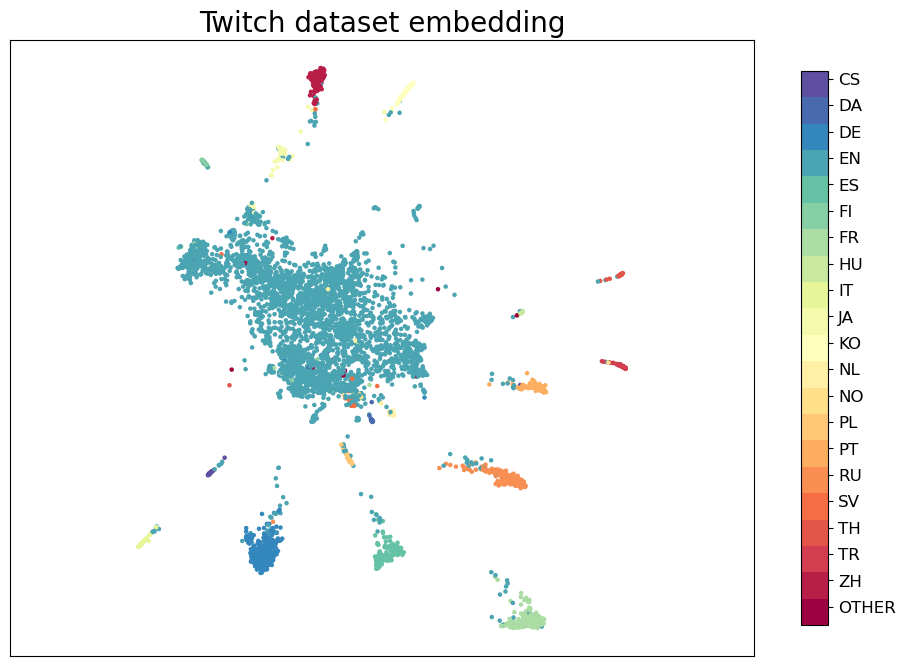

In [68]:
twitch['log_num_views'] = [int(x) for x in np.round(np.log10(twitch.views+1))]

## plot 
plt.figure(figsize=(12,8))
plt.scatter(twitch[twitch.log_num_views>5].X, twitch[twitch.log_num_views>5].Y, c=[lang_dict[i] for i in twitch[twitch.log_num_views>5].language], cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
ax = plt.colorbar(boundaries=np.arange(num_lang+1)-0.5, shrink=0.9)
ax.set_ticks(np.arange(num_lang)+.2)
ax.set_ticklabels(lang_dict.keys(), fontsize=12)
plt.xticks([])
plt.yticks([])
plt.title('Twitch dataset embedding', fontsize=20);


### t-SNE views of the above

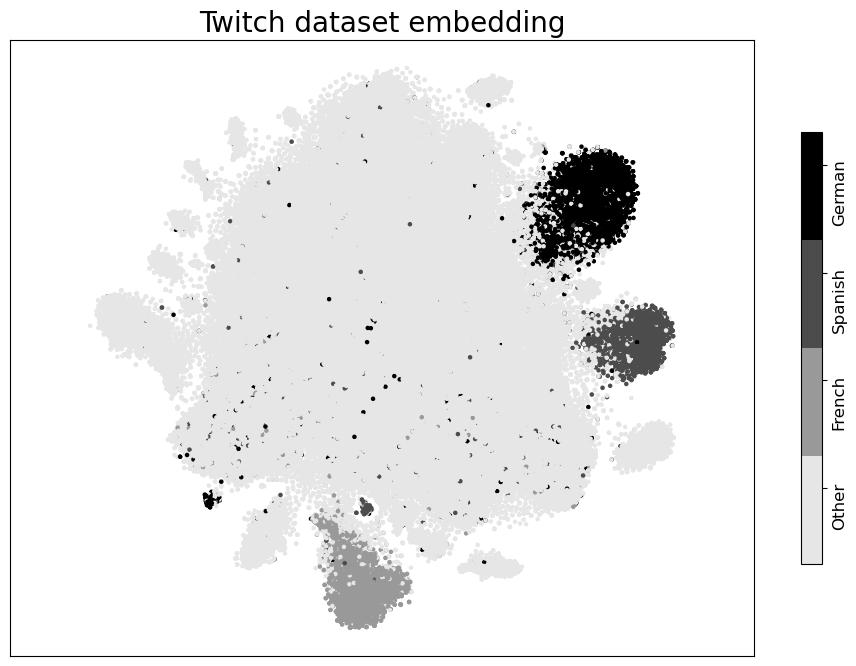

In [69]:
## plot - change ticklabels as required
plt.figure(figsize=(12,8))
plt.scatter(twitch.X_tsne, twitch.Y_tsne, c=twitch.color, cmap=greyscale, s=5)
plt.gca().set_aspect('equal', 'datalim')
ax = plt.colorbar(boundaries=np.arange(5)-0.5, shrink=0.7)
ax.set_ticks(np.arange(4)+.2)
ax.set_ticklabels(['Other']+languages, rotation=90, fontsize=12)
plt.xticks([])
plt.yticks([])
plt.title('Twitch dataset embedding', fontsize=20);


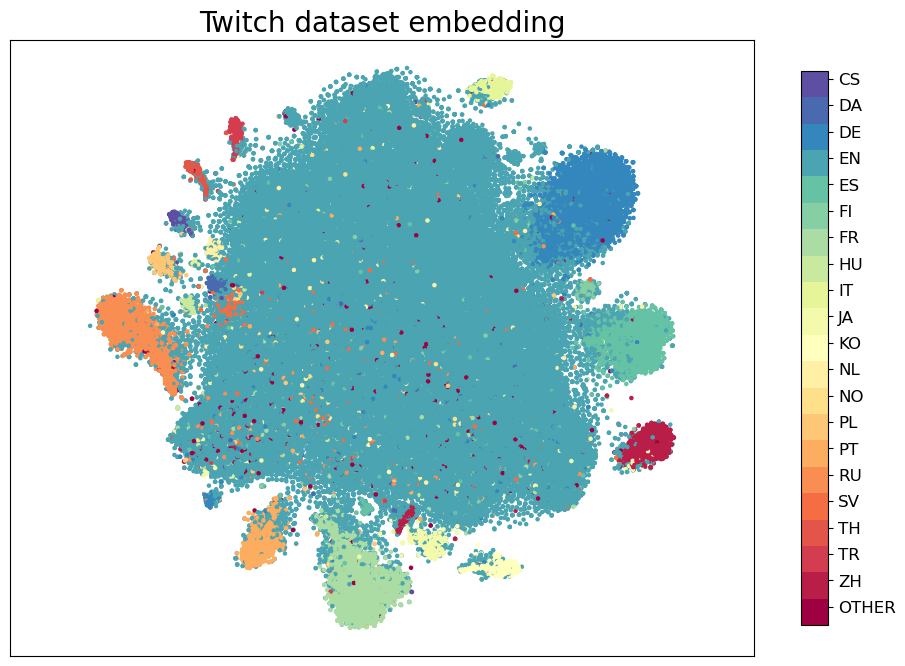

In [70]:
## plot - change ticklabels as required
plt.figure(figsize=(12,8))
plt.scatter(twitch.X_tsne, twitch.Y_tsne, c=[lang_dict[i] for i in twitch.language], cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
ax = plt.colorbar(boundaries=np.arange(num_lang+1)-0.5, shrink=0.9)
ax.set_ticks(np.arange(num_lang)+.2)
ax.set_ticklabels(lang_dict.keys(), fontsize=12)
plt.xticks([])
plt.yticks([])
plt.title('Twitch dataset embedding', fontsize=20);


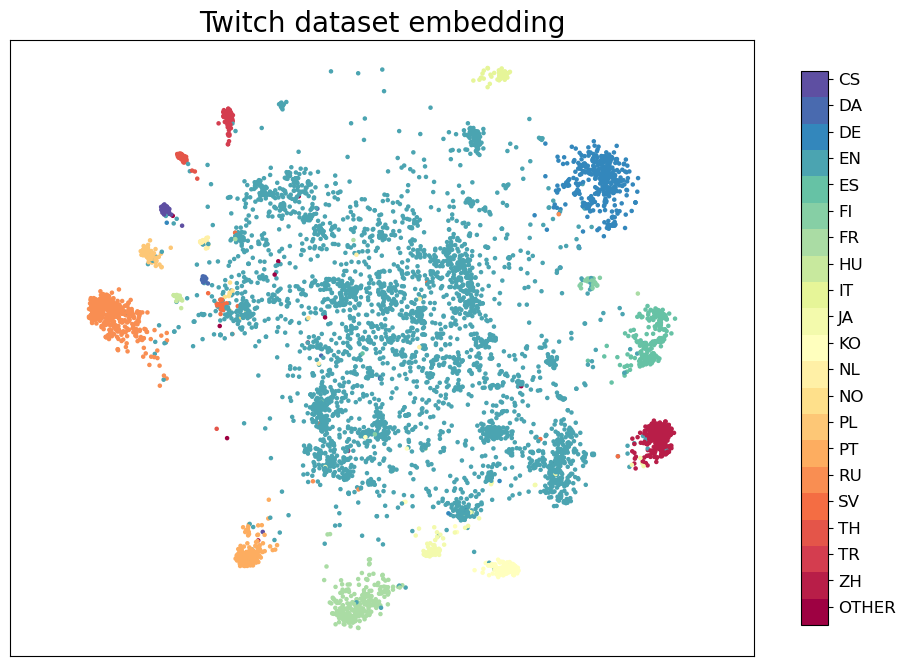

In [71]:
## plot 
plt.figure(figsize=(12,8))
plt.scatter(twitch[twitch.log_num_views>5].X_tsne, twitch[twitch.log_num_views>5].Y_tsne, c=[lang_dict[i] for i in twitch[twitch.log_num_views>5].language], cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
ax = plt.colorbar(boundaries=np.arange(num_lang+1)-0.5, shrink=0.9)
ax.set_ticks(np.arange(num_lang)+.2)
ax.set_ticklabels(lang_dict.keys(), fontsize=12)
plt.xticks([])
plt.yticks([])
plt.title('Twitch dataset embedding', fontsize=20);
